In [5]:
# Enable inline plots in the notebook
%matplotlib inline

# Import library functions needed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set default figure size
plt.rcParams['figure.figsize'] = [6,6]

# Function that is used to plot spike times
def rasterplot(ax, x, y, x_label, y_label):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [6]:
# To simulate the spikes from the receptor neurons you will need an additional neuron constructor defined as

def spike_generator(spike_times):
    # Generates spikes at time points defined by the sorted list 'spike_t'
    return {
        'type'      : 'generator',
        'spike_t'   : spike_times              # Array of spike times, separated by at least dt
}

# To incorporate this neuron type in the simulator you will need to update the spikegen(dt,t,neurons) function

def spikegen(dt, t, neurons):
    # This function implements the non-linear spike generation mechanism
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif_cic','lif']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
        elif n['type'] == 'generator':
            j = np.searchsorted(n['spike_t'], t, side='right')
            if j>0 and t-n['spike_t'][j-1]<dt:
                spikes.append(i)
    return spikes

# With these modifications of the simulator code you should be able to simulate the receptor neurons using
# spike_generator neurons initialized with the spike time arrays produced by the data generator code above.

# The construction of neurons and configuration of synapses should be done in a similar way as in SNN Exercise 1.

In [7]:
def lif_cic_neuron(I_syn, u_rest=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3):
    # LIF neuron with a constant input current I_syn
    return {
        'type'    : 'lif_cic',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'u_rest'  : u_rest,                    # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'I_syn'   : I_syn,                     # Postsynaptic current [Ampere]
    }

def lif_neuron(num_synapses,  u_rest=-65e-3, u_reset=-80e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3, tau_syn=50e-3):
    # LIF neuron with current-based synapses (see lecture)
    return {
        'type'    : 'lif',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'u_rest'  : u_rest,                    # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'tau_syn' : tau_syn,                   # Synapse time constant [second] (can also be an array)
        'I_syn'   : np.zeros(num_synapses),    # Postsynaptic currents [Ampere]
        'w_syn'   : np.zeros(num_synapses)     # Synaptic weights [Ampere]
    }

def integrate(dt, t, neurons):
    # This function integrates the membrane potential, synaptic currents etc one timestep dt
    for n in neurons:
        if n['type'] == 'lif_cic':
            dudt = (n['u_rest'] - n['u'] + n['R']*n['I_syn']) / n['tau_m']
            n['u'] += dt*dudt
        elif n['type'] == 'lif':
            didt = np.divide(-n['I_syn'], n['tau_syn'])
            n['I_syn'] += dt*didt
            dudt = (n['u_rest'] - n['u'] + n['R']*sum(n['I_syn'])) / n['tau_m']
            n['u'] += dt*dudt

def snn_update(dt, t, neurons, connections):
    # This function updates the state of a spiking neural network by calling the functions above
    spikes = spikegen(dt, t, neurons)
    for (post, syn, pre) in connections:
        for spike in spikes:
            if spike == pre:
                if neurons[post]['type'] == 'lif':
                    neurons[post]['I_syn'][syn] += neurons[post]['w_syn'][syn]
                else:
                    print('Error: Spike sent to neuron type without synapses')
    integrate(dt, t, neurons)
    return spikes

In [63]:
spikeTiming = [1]

# Right to left
#spike1 = spike_generator([0.30])
#spike2 = spike_generator([0.25])
#spike3 = spike_generator([0.20])
#spike4 = spike_generator([0.15])
#spike5 = spike_generator([0.1])
# Left to right
spike1 = spike_generator([0.10])
spike2 = spike_generator([0.15])
spike3 = spike_generator([0.20])
spike4 = spike_generator([0.25])
spike5 = spike_generator([0.30])

inp1 = lif_neuron(1)
inp2 = lif_neuron(1)
inp3 = lif_neuron(1)
inp4 = lif_neuron(1)
inp5 = lif_neuron(1)

feed_G1_1 = lif_neuron(1)
feed_G1_2 = lif_neuron(1)
feed_G1_3 = lif_neuron(1)
feed_G1_4 = lif_neuron(1)

relay_G1_1 = lif_neuron(2)
relay_G1_2 = lif_neuron(2)
relay_G1_3 = lif_neuron(2)
relay_G1_4 = lif_neuron(2) 

feed_G2_1 = lif_neuron(1)
feed_G2_2 = lif_neuron(1)
feed_G2_3 = lif_neuron(1)
feed_G2_4 = lif_neuron(1)

relay_G2_1 = lif_neuron(2)
relay_G2_2 = lif_neuron(2)
relay_G2_3 = lif_neuron(2)
relay_G2_4 = lif_neuron(2) 

output1 = lif_neuron(4)
output2 = lif_neuron(4)

neurons = [spike1,#0
          spike2,#1
          spike3,#2
          spike4,#3
          spike5,#4
          inp1,#5
          inp2,#6
          inp3,#7
          inp4,#8
          inp5,#9
          feed_G1_1,#10
          feed_G1_2,#11
          feed_G1_3,#12
          feed_G1_4,#13
          relay_G1_1,#14
          relay_G1_2,#15
          relay_G1_3,#16
          relay_G1_4,#17
          feed_G2_1,#18
          feed_G2_2,#19
          feed_G2_3,#20
          feed_G2_4,#21
          relay_G2_1,#22
          relay_G2_2,#23
          relay_G2_3,#24
          relay_G2_4,#25
          output1,#26
          output2]#27

connections = [
    #Input
    [5,0,0],
    [6,0,1],
    [7,0,2],
    [8,0,3],
    [9,0,4],

    #Feed forward inhib G1
    [10,0,5],
    [11,0,6],
    [12,0,7],
    [13,0,8],

    #Relays G1
    [14,1,10],
    [14,0,6],
    [15,1,11],
    [15,0,7],
    [16,1,12],
    [16,0,8],
    [17,1,13],
    [17,0,9],
    
    #Output G1
    [26,0,14],
    [26,1,15],
    [26,2,16],
    [26,3,17],
    
    #Feed forward inhib G2
    [21,0,6],
    [20,0,7],
    [19,0,8],
    [18,0,9],
    
    #Relays G2
    [22,1,18],
    [22,0,8],
    [23,1,19],
    [23,0,7],
    [24,1,20],
    [24,0,6],
    [25,1,21],
    [25,0,5],
    
    #Output G2
    [27,0,22],
    [27,1,23],
    [27,2,24],
    [27,3,25]
    
]

wsyn = 350e-12

for i in range(len(neurons)): 
    if(neurons[i]["type"] == "generator"):
        continue
    try:
        neurons[i]['w_syn'][0] = wsyn
        neurons[i]['w_syn'][1] = wsyn
        neurons[i]['w_syn'][2] = wsyn
        neurons[i]['w_syn'][3] = wsyn
    except:
        pass
    if(i >13 and i < 18):
        neurons[i]['w_syn'][1] = -wsyn
    if(i >21 and i < 26):
        neurons[i]['w_syn'][1] = -wsyn 
    
    if(i == 26):
        neurons[i]['w_syn'][0] = wsyn/2
        neurons[i]['w_syn'][1] = wsyn/2
        neurons[i]['w_syn'][2] = wsyn/2
        neurons[i]['w_syn'][3] = wsyn/2
    if(i == 27):
        neurons[i]['w_syn'][0] = wsyn/2
        neurons[i]['w_syn'][1] = wsyn/2
        neurons[i]['w_syn'][2] = wsyn/2
        neurons[i]['w_syn'][3] = wsyn/2


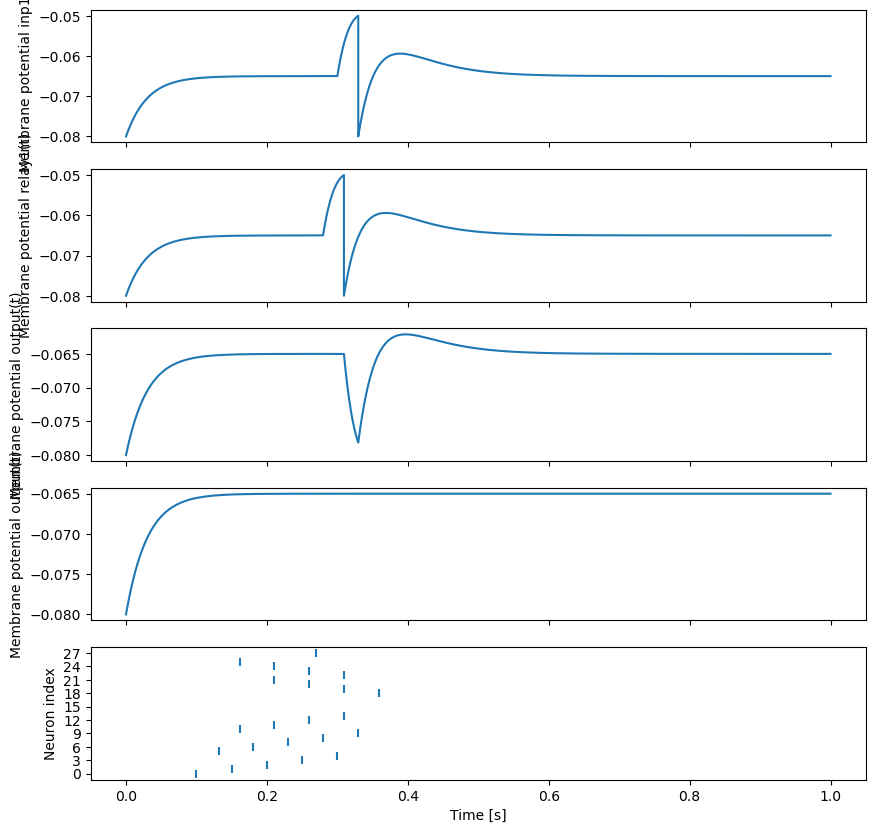

In [64]:
dt = 1e-5
t = 0

t0 = t
tv = []
u1 = []
u2 = []
u3 = []
u_out = []
t_spike = []
n_spike = []

while t < t0+1:

    # Update the network
    spikes = snn_update(dt, t, neurons, connections)
    
    # Store membrane potentials of n1 and n2 for plotting/analysis
    tv.append(t)
    u1.append(inp5['u'])
    u2.append(feed_G1_4['u'])
    u3.append(relay_G1_4['u'])
    u_out.append(output1['u'])
    
    # Store spikes needed for plotting/analysis
    if len(spikes)>0:
        for s in spikes:
            t_spike.append(t)
            n_spike.append(s)

    # Timestep completed
    t += dt
    
plt.rcParams['figure.figsize'] = [10, 10]
fig,(ax1,ax2,ax3,ax4, ax5) = plt.subplots(5,1, sharex=True)
ax1.plot(tv,u1); ax1.set_ylabel('Membrane potential inp1(t)')
ax2.plot(tv,u2); ax2.set_ylabel('Membrane potential relay1(t)')
ax3.plot(tv,u3); ax3.set_ylabel('Membrane potential output(t)')
ax4.plot(tv,u_out); ax4.set_ylabel('Membrane potential output(t)')
rasterplot(ax5, t_spike, n_spike,'Time [s]','Neuron index')

we go Right


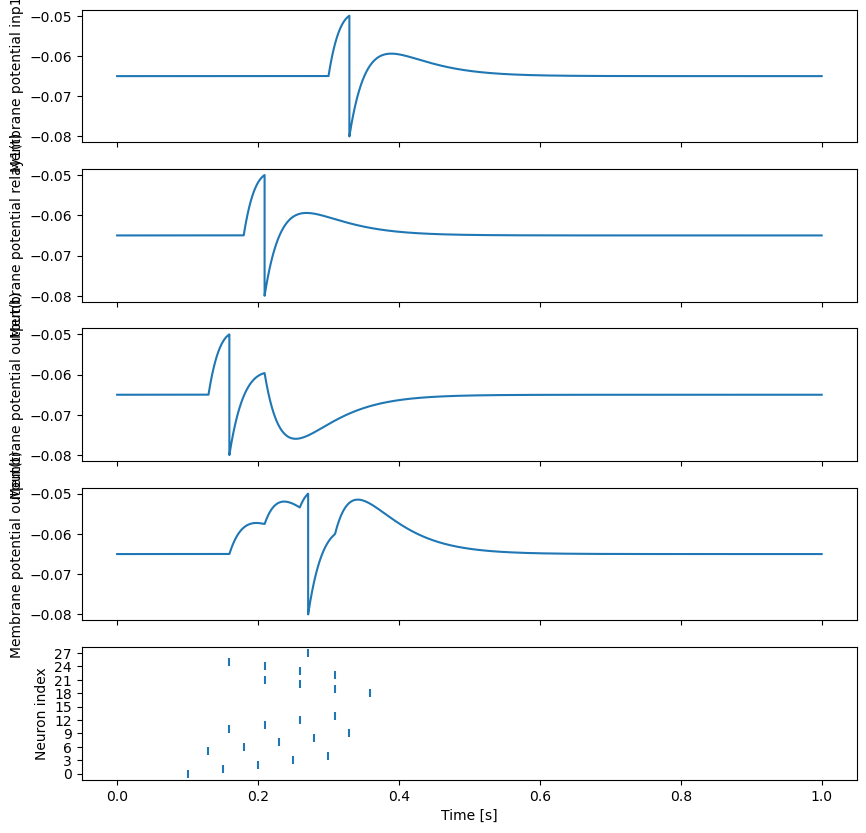

In [65]:
dt = 1e-5
t = 0

t0 = t
tv = []
u1 = []
u2 = []
u3 = []
u_out = []
t_spike = []
n_spike = []
output1_count = 0
output2_count = 0

while t < t0+1:

    # Update the network
    spikes = snn_update(dt, t, neurons, connections)
    
    output1_count += spikes.count(output1)
    output2_count += spikes.count(output2)
    
    # Store membrane potentials of n1 and n2 for plotting/analysis
    tv.append(t)
    u1.append(inp5['u'])
    u2.append(feed_G2_4['u'])
    u3.append(relay_G2_4['u'])
    u_out.append(output2['u'])
    
    # Store spikes needed for plotting/analysis
    if len(spikes)>0:
        for s in spikes:
            t_spike.append(t)
            n_spike.append(s)

    # Timestep completed
    t += dt

plt.rcParams['figure.figsize'] = [10, 10]
fig,(ax1,ax2,ax3,ax4, ax5) = plt.subplots(5,1, sharex=True)
ax1.plot(tv,u1); ax1.set_ylabel('Membrane potential inp1(t)')
ax2.plot(tv,u2); ax2.set_ylabel('Membrane potential relay1(t)')
ax3.plot(tv,u3); ax3.set_ylabel('Membrane potential output(t)')
ax4.plot(tv,u_out); ax4.set_ylabel('Membrane potential output(t)')
rasterplot(ax5, t_spike, n_spike,'Time [s]','Neuron index')

output1_count = n_spike.count(26) #How many spikes the output does the int is the position of the neuron in the connections
output2_count = n_spike.count(27)

if output1_count > output2_count:
    print("we go Left")
elif output1_count < output2_count:
    print("we go Right")
else:
    print("stand still")